In [147]:
#Always run
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials

import warnings
warnings.filterwarnings("ignore")
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib
import copy
import numpy as np
import pandas as pd
from pandas_datareader import data, wb
from sklearn.metrics import mean_squared_error
import datetime
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Part A
**Stock Forecast**
Part A: The forecasting has two part - a) Time series forecast using ARIMA b) Multivariate Timeseries Forecasting model using Linear regression and Random Forest

# Note - Below Code needs to be modified for the 8 companies

In [148]:

yahoo_financials = YahooFinancials('HDFCBANK.NS')
#yahoo_financials = YahooFinancials('BAJFINANCE.NS')
#yahoo_financials = YahooFinancials('JSWSTEEL.NS')
#yahoo_financials = YahooFinancials('TATASTEEL.NS')
#yahoo_financials = YahooFinancials('BRITANNIA.NS')
#yahoo_financials = YahooFinancials('ITC.NS')
#yahoo_financials = YahooFinancials('INFY.NS')
#yahoo_financials = YahooFinancials('TCS.NS')

data = yahoo_financials.get_historical_price_data(start_date='2011-01-01', 
                                                  end_date='2021-01-01',time_interval='weekly')
df = pd.DataFrame(data['HDFCBANK.NS']['prices'])
#df = pd.DataFrame(data['BAJFINANCE.NS']['prices'])
#df = pd.DataFrame(data['JSWSTEEL.NS']['prices'])
#df = pd.DataFrame(data['TATASTEEL.NS']['prices'])
#df = pd.DataFrame(data['BRITANNIA.NS']['prices'])
#df = pd.DataFrame(data['ITC.NS']['prices'])
#df = pd.DataFrame(data['INFY.NS']['prices'])
#df = pd.DataFrame(data['TCS.NS']['prices'])
df['formatted_date'] = pd.to_datetime(df['formatted_date'])
df = df[['formatted_date','adjclose']]
df = df.set_index('formatted_date')
df=df.rename(columns={"adjclose": "Price"})
#df.head()

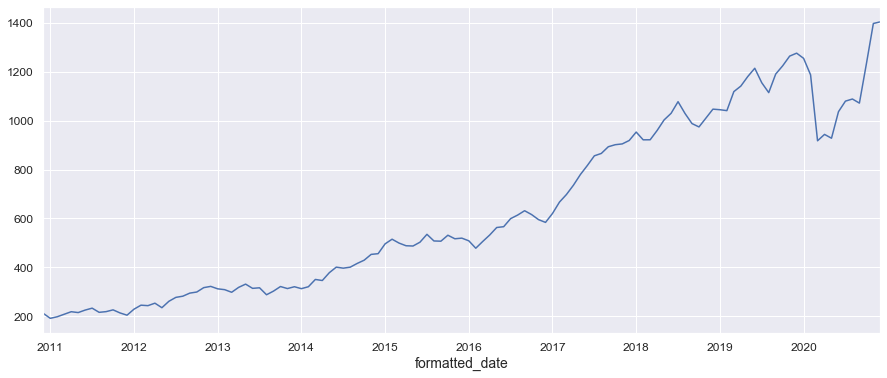

In [149]:
y = df['Price'].resample('MS').mean()
y.plot(figsize=(15, 6))
plt.show()

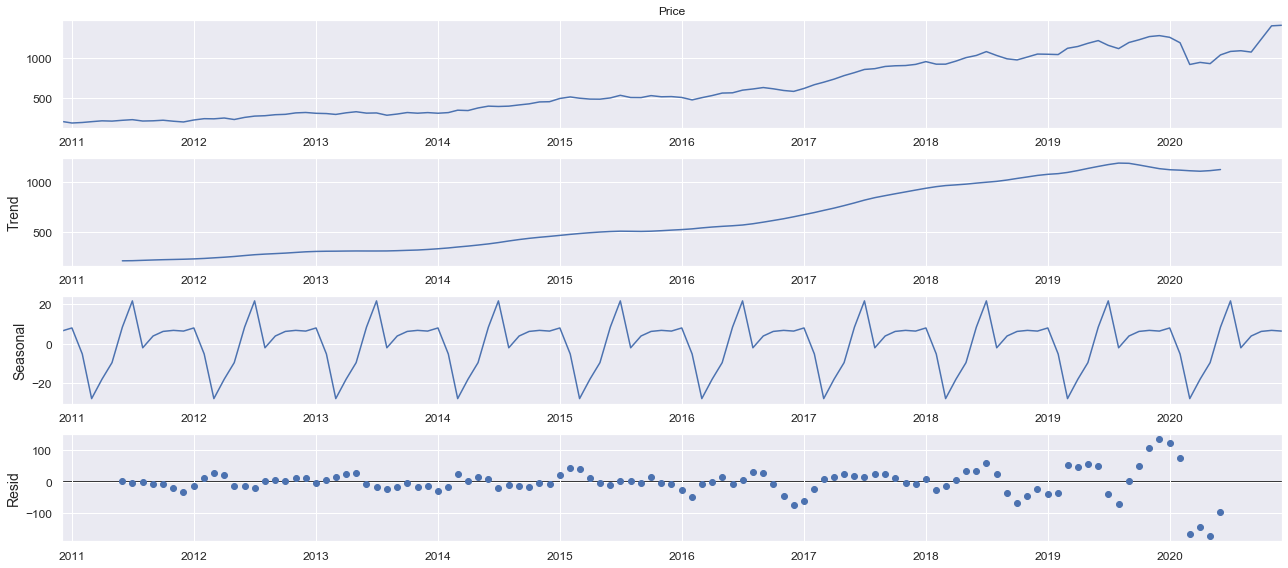

In [150]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

# Forecasting with ARIMA
Parameter identification

In [151]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Example of parameter combination for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))

Example of parameter combination for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)


In [152]:
ord_min=(0,0,0)
seas_min=(0,0,0,12)
cur_max=9999999999999999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            if cur_max>results.aic:
                ord_min=param
                seas_min=param_seasonal
                cur_max=results.aic
        except:
            continue
print('ARIMA{}x{}12 - AIC:{}'.format(ord_min,seas_min,cur_max))

ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:992.310212472688


In [153]:
mod = sm.tsa.statespace.SARIMAX(y,order=ord_min,seasonal_order=seas_min,
                                enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2160      0.090      2.404      0.016       0.040       0.392
ar.S.L12      -0.7616      0.287     -2.651      0.008      -1.325      -0.199
ma.S.L12      -0.3216      0.299     -1.076      0.282      -0.907       0.264
sigma2      2042.3559    168.190     12.143      0.000    1712.709    2372.003


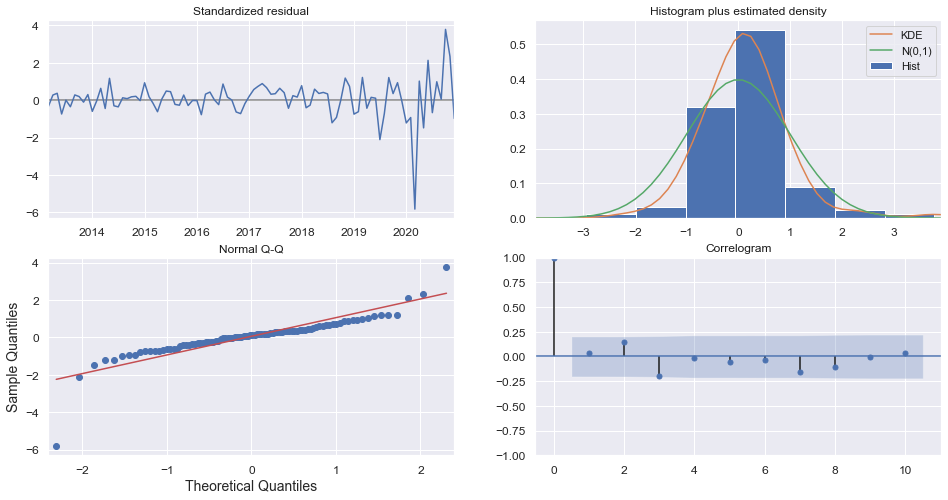

In [154]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

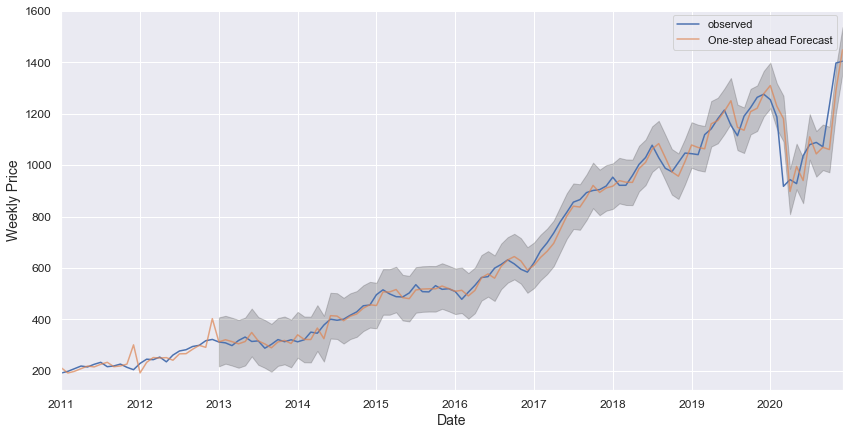

In [155]:
pred = results.get_prediction(start=pd.to_datetime('2011-01-01'), dynamic=False)

pred_ci = results.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=False).conf_int()

ax = y['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Weekly Price')
plt.legend()

plt.show()

In [156]:
y_forecasted = pred.predicted_mean
y_truth = y['2011-01-01':]

# Compute the mean square error
#mse = (((y_forecasted - y_truth)*(pow(10,-1))) ** 2).mean()
mse = mean_squared_error(y_truth,y_forecasted) 
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 1775.29
The Root Mean Squared Error of our forecasts is 42.13


In [157]:
def percentage_change(col1,col2):
        return ((col2 - col1) / col1) * 100

accuracy_arima = percentage_change(y_forecasted , y_truth)
accuracy_arima = accuracy_arima.abs()
print("Average accuracy in case of ARIMA is "+str(100-accuracy_arima.mean()))

Average accuracy in case of ARIMA is 95.59683871311246


# Ensemble Models- Linear Regression and Random Forest

# Note - Below Code needs to be modified for the 8 companies

In [158]:
yahoo_financials = YahooFinancials('HDFCBANK.NS')
#yahoo_financials = YahooFinancials('BAJFINANCE.NS')
#yahoo_financials = YahooFinancials('JSWSTEEL.NS')
#yahoo_financials = YahooFinancials('TATASTEEL.NS')
#yahoo_financials = YahooFinancials('BRITANNIA.NS')
#yahoo_financials = YahooFinancials('ITC.NS')
#yahoo_financials = YahooFinancials('INFY.NS')
#yahoo_financials = YahooFinancials('TCS.NS')

data = yahoo_financials.get_historical_price_data(start_date='2011-01-01', 
                                                  end_date='2021-01-01',time_interval='weekly')
df = pd.DataFrame(data['HDFCBANK.NS']['prices'])
#df = pd.DataFrame(data['BAJFINANCE.NS']['prices'])
#df = pd.DataFrame(data['JSWSTEEL.NS']['prices'])
#df = pd.DataFrame(data['TATASTEEL.NS']['prices'])
#df = pd.DataFrame(data['BRITANNIA.NS']['prices'])
#df = pd.DataFrame(data['ITC.NS']['prices'])
#df = pd.DataFrame(data['INFY.NS']['prices'])
#df = pd.DataFrame(data['TCS.NS']['prices'])

df['formatted_date'] = pd.to_datetime(df['formatted_date'])
df = df[['adjclose','volume','formatted_date']]
df=df.rename(columns={"adjclose": "Price"})
df["day"] = df['formatted_date'].map(lambda x: x.day)
df["month"] = df['formatted_date'].map(lambda x: x.month)
df["year"] = df['formatted_date'].map(lambda x: x.year)
df = df.set_index('formatted_date')
df = df.sort_values('formatted_date')
df.isnull().sum()
#df.head()

Price     0
volume    0
day       0
month     0
year      0
dtype: int64

In [159]:
df.describe()

,Price,volume,day,month,year
count,522.000000,5.220000e+02,522.000000,522.000000,522.000000
mean,634.638654,2.814397e+07,15.745211,6.526820,2015.490421
std,350.405025,2.181738e+07,8.816874,3.448587,2.879690
min,188.401215,5.192280e+06,1.000000,1.000000,2010.000000
25%,316.034058,1.405107e+07,8.000000,4.000000,2013.000000
50%,522.075928,2.141443e+07,16.000000,7.000000,2015.500000
75%,964.307892,3.432155e+07,23.000000,9.750000,2018.000000
max,1440.849976,2.093362e+08,31.000000,12.000000,2020.000000


In [160]:
for k, v in df.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(df)[0]
        print("Column %s outliers = %.2f%%" % (k, perc))

Column Price outliers = 0.00%
Column volume outliers = 6.13%
Column day outliers = 0.00%
Column month outliers = 0.00%
Column year outliers = 0.00%


In [161]:
#import seaborn as sns
#fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 10))
#index = 0
#axs = axs.flatten()
#for k,v in df.items():
# Use below code only if 2 graph plots are required
#    if index==2:
#        break
#########################################
#    sns.distplot(v, ax=axs[index])
#    index += 1
#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

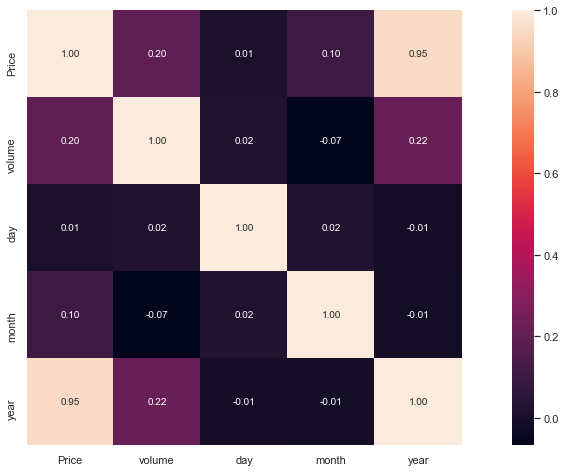

In [162]:
import seaborn as sns
# Correlation Matrix
cor_matrix = np.corrcoef(df[df.columns].values.T) 
# We transpose to get the data by columns. Columns become rows.
sns.set(font_scale=1)
cor_heat_map = sns.heatmap(cor_matrix,
 cbar=True,
 annot=True,
 square=True,
 fmt='.2f',
 annot_kws={'size':10},
 yticklabels=df.columns,
 xticklabels=df.columns)

plt.show()

In [163]:
# Creating deep copy of original dataframe
dff=df.copy(deep=True)

In [164]:
x = dff.drop(['Price'],axis = 1)
y = dff['Price']

In [165]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state = 33)

In [166]:
# Applying linear regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)

In [167]:
cdf = pd.DataFrame(lr.coef_, x.columns, columns=['Coefficients'])
#print(cdf)

In [168]:
#R^2 score
lr.score(X_test, y_test)

0.9051474506183212

In [169]:
# Applying random forest
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
y_pred_rfr = rfr.predict(X_test)

In [170]:
rfr.decision_path(x)

(<522x45626 sparse matrix of type '<class 'numpy.int64'>'
 	with 505822 stored elements in Compressed Sparse Row format>,
 array([    0,   447,   900,  1361,  1818,  2273,  2750,  3191,  3650,
         4083,  4554,  5019,  5486,  5929,  6380,  6829,  7278,  7729,
         8174,  8617,  9070,  9529, 10000, 10451, 10904, 11361, 11824,
        12307, 12768, 13243, 13702, 14175, 14624, 15089, 15550, 15995,
        16464, 16899, 17376, 17817, 18266, 18691, 19160, 19613, 20068,
        20521, 20962, 21415, 21868, 22313, 22790, 23247, 23714, 24157,
        24620, 25089, 25540, 25973, 26420, 26879, 27348, 27813, 28258,
        28715, 29172, 29617, 30078, 30515, 30978, 31449, 31906, 32359,
        32818, 33261, 33722, 34207, 34648, 35117, 35564, 36019, 36468,
        36903, 37350, 37815, 38294, 38751, 39236, 39699, 40136, 40587,
        41068, 41503, 41964, 42429, 42900, 43355, 43800, 44245, 44712,
        45173, 45626], dtype=int32))

In [171]:
#R^2 score
rfr.score(X_test,y_test)

0.9871841359844223

In [172]:
dff['PRED_Price_LR']=lr.predict(df.drop(['Price'],axis = 1))
dff['PRED_Price_RF']=rfr.predict(df.drop(['Price'],axis = 1))

In [173]:
#dff.head(10)

In [174]:
def percentage_change(col1,col2):
        return ((col2 - col1) / col1) * 100

dff['Accuracy_LR'] = percentage_change(dff['PRED_Price_LR'] , dff['Price'])
dff['Accuracy_RF'] = percentage_change(dff['PRED_Price_RF'] , dff['Price'])
#df['Accuracy_RF'] = (df.PRED_Price_RF - df.Price) / df.Price * 100

In [175]:
mse_lr = mean_squared_error(dff['Price'],dff['PRED_Price_LR'])
mse_rf = mean_squared_error(dff['Price'],dff['PRED_Price_RF'])
print('The Mean Squared Error of LR forecast is {}'.format(round(mse_lr, 2)))
print('The Root Mean Squared Error of LR forecast is {}'.format(round(np.sqrt(mse_lr), 2)))
print('The Mean Squared Error of RF forecast is {}'.format(round(mse_rf, 2)))
print('The Root Mean Squared Error of RF forecast is {}'.format(round(np.sqrt(mse_rf), 2)))


The Mean Squared Error of LR forecast is 9617.91
The Root Mean Squared Error of LR forecast is 98.07
The Mean Squared Error of RF forecast is 575.09
The Root Mean Squared Error of RF forecast is 23.98


In [176]:
dff2=dff.copy(deep=True)
dff2['Accuracy_LR'] = dff2['Accuracy_LR'].abs()
dff2['Accuracy_RF'] = dff2['Accuracy_RF'].abs()
dff2.head()
print("Average accuracy in case of LR is "+str(100-dff2["Accuracy_LR"].mean()))
print("Average accuracy in case of RF is "+str(100-dff2["Accuracy_RF"].mean()))

Average accuracy in case of LR is 76.61268132810105
Average accuracy in case of RF is 98.30910202007445


In [177]:
#import pandas as pd
#import yfinance as yf
#from yahoofinancials import YahooFinancials

In [178]:
# Use this code in case daily, weekly, monthly data is needed
#yahoo_financials = YahooFinancials('HDFCBANK.NS')

#data = yahoo_financials.get_historical_price_data(start_date='2020-01-01', end_date='2021-01-01',time_interval='daily')

#df = pd.DataFrame(data['HDFCBANK.NS']['prices'])
#df = df.drop('date', axis=1).set_index('formatted_date')

# Part B 
# Common Functions

In [179]:
def sharpe_ratio(rets):
    return rets.mean() / rets.std()

In [180]:
def positions(x, theta):
    M = len(theta) - 2
    T = len(x)
    Ft = np.zeros(T)
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t - 1]]])
        Ft[t] = np.tanh(np.dot(theta, xt))
    return Ft

In [181]:
def returns(Ft, x, delta):
    T = len(x)
    rets = Ft[0:T - 1] * x[1:T] - delta * np.abs(Ft[1:T] - Ft[0:T - 1])
    return np.concatenate([[0], rets])

In [182]:
def gradient(x, theta, delta):
    Ft = positions(x, theta)
    rets = returns(Ft, x, delta)
    T = len(x)
    M = len(theta) - 2
    
    A = np.mean(rets)
    B = np.mean(np.square(rets))
    S = A / np.sqrt(B - A ** 2)
# Initialising gradient
    grad = np.zeros(M + 2)  
# Stores past dF dtheta
    dFpdtheta = np.zeros(M + 2)  
    
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t-1]]])
        dRdF = -delta * np.sign(Ft[t] - Ft[t-1])
        dRdFp = x[t] + delta * np.sign(Ft[t] - Ft[t-1])
        dFdtheta = (1 - Ft[t] ** 2) * (xt + theta[-1] * dFpdtheta)
        dSdtheta = (dRdF * dFdtheta + dRdFp * dFpdtheta)
        grad = grad + dSdtheta
        dFpdtheta = dFdtheta

        
    return grad, S

In [183]:
def train(x, epochs=500, M=5, commission=0.0025, learning_rate = 0.1):
    theta = np.ones(M + 2)
# store sharpes over time
    sharpes = np.zeros(epochs) 
    for i in range(epochs):
        grad, sharpe = gradient(x, theta, commission)
        theta = theta + grad * learning_rate

        sharpes[i] = sharpe
    
    
    print("finished training")
    return theta, sharpes

# HDFC Bank

# Note - Below Code needs to be modified for the 8 companies

In [184]:
from pandas_datareader import data
start = pd.to_datetime('2011-01-01')
end = pd.to_datetime('2021-01-01')

hdfc_df = data.DataReader('HDFCBANK.NS', 'yahoo', start , end)

#hdfc_df = data.DataReader('BAJFINANCE.NS', 'yahoo', start , end)
#hdfc_df = data.DataReader('JSWSTEEL.NS', 'yahoo', start , end)
#hdfc_df = data.DataReader('TATASTEEL.NS', 'yahoo', start , end)
#hdfc_df = data.DataReader('BRITANNIA.NS', 'yahoo', start , end)
#hdfc_df = data.DataReader('ITC.NS', 'yahoo', start , end)
#hdfc_df = data.DataReader('INFY.NS', 'yahoo', start , end)
#hdfc_df = data.DataReader('TCS.NS', 'yahoo', start , end)

hdfc_df['Price']=hdfc_df['Adj Close']

In [185]:
df=hdfc_df[['Price','Volume']]
df.head()
df.index = pd.to_datetime(df.index, unit='s')
rets = df['Price'].diff()[1:]

In [186]:
# First we normalize data
x = np.array(rets)
x = (x - np.mean(x)) / np.std(x) 



# We train the model using a data for last 2 years
x_train=x[-495:]
x_test=x

In [187]:
# We now train the model with lookback window of 10
theta, sharpes = train(x_train, epochs=2000, M=10, commission=0, learning_rate=.05)

finished training


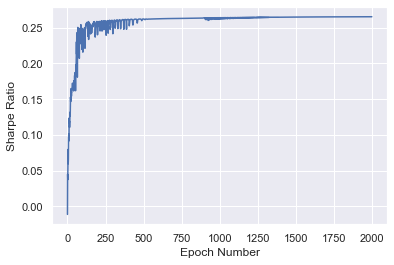

In [188]:
# We now see how sharpe ratio converges to a maximum
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(sharpes)
plt.xlabel('Epoch Number')
plt.ylabel('Sharpe Ratio');

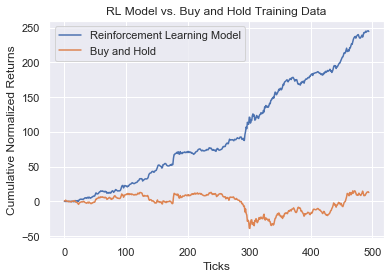

In [189]:
train_returns = returns(positions(x_train, theta), x_train, 0)
plt.plot((train_returns).cumsum(), label="Reinforcement Learning Model")
plt.plot(x_train.cumsum(), label="Buy and Hold")
plt.xlabel('Ticks')
plt.ylabel('Cumulative Normalized Returns');
plt.legend()
plt.title("RL Model vs. Buy and Hold Training Data");

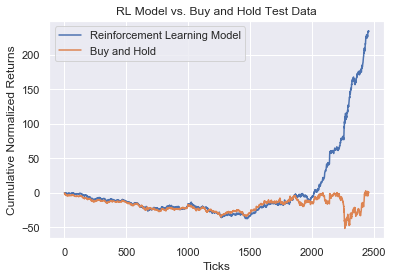

In [190]:
test_returns = returns(positions(x_test, theta), x_test, 0)
plt.plot((test_returns).cumsum(), label="Reinforcement Learning Model")
plt.plot(x_test.cumsum(), label="Buy and Hold")
plt.xlabel('Ticks')
plt.ylabel('Cumulative Normalized Returns');
plt.legend()
plt.title("RL Model vs. Buy and Hold Test Data");

In [191]:
cum_ret_train = train_returns.cumsum()[-1]-x_train.cumsum()[-1]
cum_ret_test = test_returns.cumsum()[-1]-x_test.cumsum()[-1]
print('Cumulative difference in Normalized return for training set is {}%'.format(round(cum_ret_train, 2)))
print('Cumulative difference in Normalized return for test set is {}%'.format(round(cum_ret_test, 2)))

Cumulative difference in Normalized return for training set is 231.74%
Cumulative difference in Normalized return for test set is 233.73%


In [192]:
# Example of linear regression plot
#x = np.array([1, 3, 5, 7])
#y = np.array([ 4, 7, 9, 8 ])
#plt.plot(x, y, 'o')
#m, b = np.polyfit(x, y, 1)
#plt.plot(x, m*x + b)
#plt.xlabel('x axis')
#plt.ylabel('y axis')